In [1]:
import json
import numpy as np
from qiskit.circuit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit_aer import Aer
from qiskit import transpile
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp,Operator, state_fidelity, Statevector, partial_trace, entropy
import random
from scipy.optimize import minimize, differential_evolution
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2 qubit entanglement detection
In this notebook I will se how we can detect 2 qubit entanglement using VQAs or similar procedures.

First we open the 4000 random unitaries form the json

In [2]:
with open(r"./random_unitaries_2q.json", "r") as f:
    loaded_data = json.load(f)

# Convert back to NumPy arrays
loaded_matrices = [
    np.array(data["real"]) + 1j * np.array(data["imag"])
    for data in loaded_data
]
print(len(loaded_matrices))

4000


We have now stored the 4000 complex matrices in the loaded_matrices vector.
With this 4000 unitaries we will create a set of 2000 training states and 2000 test states.


In [3]:
training = loaded_matrices[0:2000]
test = loaded_matrices[2000:4000]

In [4]:
len(training)

2000

## Geometric measure of entanglement 

The first method we will review is the entanglement detection through the geometric measure (GME). This is a monotone which provides a quantification of how close this state is to the closest possible separable state. This closeness is calculated using the fideleity:
$$F(|\psi\rangle , |\phi\rangle) = |\langle \psi | \phi \rangle|^2 $$
We de define GME as:
$$E(|\psi \rangle) = 1 - \Lambda_{\psi}^2$$
Where the $\Lambda_{\psi}$ is defined as:
$$\Lambda_{\psi}^2 = max_{|\phi\rangle \in SEP} F(|\psi\rangle , |\phi\rangle) $$
If E is zero we have that the quantum state is separable, otherwise it is entangled.

By maximazing the fidelity, we try to obtain the closest separable state to the one we want to classify. It is worth noting that this procedure is possible because the set of separable states is a convex set.

In [5]:
backend = Aer.get_backend('statevector_simulator')

For the cost function, we calculate the fidelity the two circuits by using the fidelity function provided by qiskit.

In [ ]:
def cost_fun(params,ansatz1,ansatz2,backend):
    ansatz2 = ansatz2.assign_parameters(params)
    isa_ansatz = transpile(ansatz1,backend=backend)
    isa_ansatz2 = transpile(ansatz2,backend=backend)
    sv1 = Statevector(isa_ansatz)
    sv2 = Statevector(isa_ansatz2)
    fid = state_fidelity(sv1,sv2)
    return -fid

For the benchmarking of this method, I define 3 quantum variational circuits:
1. ansatz_sep: variational quantum circuit with 6 parameters. I selected this ansatz because the 3 possible rotations (rx,ry,rz) consider every single state in the Bloch Sphere for each qubit. There is no entangling gates, which makes this ansatz separable.
2. qc: the first named qc quantum circuit creates the entangled state using the unitaries from the random unitary training dataset.
3. qc: the second qc quantum circuit creates a separable state using the unitaries from the traininf dataset.

In [ ]:
len(training)/8

In [ ]:
ansatz_sep = QuantumCircuit(2)
params = ParameterVector('θ',6)
ansatz_sep.ry(params[0],0)
ansatz_sep.rx(params[1],0)
ansatz_sep.ry(params[2],1)
ansatz_sep.rx(params[3],1)
ansatz_sep.rz(params[4],0)
ansatz_sep.rz(params[5],1)
real_label= []
q = 0
geom_entr = []
for i in range(0,int(len(training)/8),2):
    print(f'State {q}')
    q+=1
    x0 = np.random.rand(6) * 2 * np.pi
    rand_num = np.random.rand()
    # We select randomely if the generated state is entangled or not
    if rand_num <= 1/3:   
        # Entangled state generator
        real_label.append(1)
        x0 = np.random.rand(6) * 2 * np.pi
        qc =QuantumCircuit(2)
        qc.h(0)# We first create the  Bell state
        qc.cx(0,1)
        U_ = np.kron(training[i],training[i+1])# We do the tensor product and create the entangled state
        qc.unitary(Operator(U_), [0,1], label="U1⊗U2")
        qc.barrier()
    elif rand_num>1/3 and rand_num<=2/3:
        # Separated state
        real_label.append(0)
        x0 = np.random.rand(6) * 2 * np.pi
        qc =QuantumCircuit(2)
        U_ = np.kron(training[0],training[1])
        qc.unitary(Operator(U_), [0,1], label="U1⊗U2")
        qc.barrier()
    elif rand_num>2/3:
        # Non maximally entangled state
        real_label.append(1)
        r = np.random.rand(4) # We create a vector of 4 random amplitudes
        r_norm = r/np.linalg.norm(r) # We normalize the vector
        phi = np.random.rand(4) * 2 * np.pi # We create a random phase
        target_state = np.array([
            r_norm[0] * np.exp(1j * phi[0]),
            r_norm[1] * np.exp(1j * phi[1]),
            r_norm[2] * np.exp(1j * phi[2]),
            r_norm[3] * np.exp(1j * phi[3])
        ])
        target_state = Statevector(target_state)
        qc = QuantumCircuit(2)
        qc.initialize(target_state.data, [0, 1]) # We initialize the state
        qc.barrier()
    res = minimize(cost_fun,x0,args = (qc,ansatz_sep,backend),method='cobyla',tol=0.1)
    geom_entr.append(-res['fun'])
    

In [ ]:
E = [(1 - p**2) for p in geom_entr]
for i in range(len(E)):
    # I set a bound at 0.1 for classification of separable and entangled
    if E[i] < 0.01:
        E[i]=0
    elif E[i]>=0.01:
        E[i]=1
q= 0
for z in range(len(real_label)):
    if E[z]==real_label[z]:
        q+=1
print(f'The method`s accuaracy is {(q/len(real_label))*100}%')

Now, I'll try to implement the detection of non-maximally entangled 2-qubit states. These are defined by:
$$|\psi\rangle = \sum_{j=1}^{4}r_j e^{i\phi_j}|u_j\rangle$$
Where $r_j \geq 0$, $\phi_j \in [0,2\pi]$ and $\sum_{j=1}^{4}r_j = 1$. For qiskit, the basis we will take is the computational basis for the 2 qubit states such that:
* $|1\rangle == |00\rangle$
* $|2\rangle == |01\rangle$
* $|3\rangle == |10\rangle$
* $|4\rangle == |11\rangle$

In [ ]:
r = np.random.rand(4) # We create a vector of 4 random amplitudes
r_norm = r/np.linalg.norm(r) # We normalize the vector
phi = np.random.rand(4) * 2 * np.pi # We create a random phase
target_state = np.array([
    r_norm[0] * np.exp(1j * phi[0]),
    r_norm[1] * np.exp(1j * phi[1]),
    r_norm[2] * np.exp(1j * phi[2]),
    r_norm[3] * np.exp(1j * phi[3])
])
target_state = Statevector(target_state)
qc = QuantumCircuit(2)
qc.initialize(target_state.data, [0, 1]) 

Once non-maximally entangled states are used, the 1-D classification is not as clear as with only maximally entangled and serparable states. For the purpose of increasing the result a 1-D SVD, as it was proposed may be a good idea.

# 3 qubits
First, I will if the entanglement geometric monotone can differenciate for 3 qubit pure separable and entangled states.

For 3 qubits, as in the [NNpaper](https://www.nature.com/articles/s41598-024-68213-0), we consider the 4 possible classes os pure states:, which will be generated using:

3. W entangled state:  $|\psi_W\rangle = K_W \left( a|001\rangle + b|010\rangle + c|100\rangle + d|000\rangle \right)$



\begin{aligned}
K_{\text{GHZ}} &= \frac{1}{1 + \cos(\delta) \sin(\delta) \cos(\alpha) \cos(\beta) \cos(\varphi)} \\
K_W &= \frac{1}{\sqrt{a^2 + b^2 + c^2 + d^2}}
\end{aligned}

Some of this parameters are bounded:$(a , b ,c,d)\in (0,1)$.

1. Separable:  $|\psi_{\text{sep}}^{\text{rand}}\rangle_3 = U_1^{\text{rand}} |0\rangle \otimes U_2^{\text{rand}} |0\rangle \otimes U_3^{\text{rand}} |0\rangle$

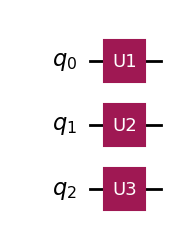

In [6]:
qc = QuantumCircuit(3)
qc.unitary(Operator(training[0]), [0], label="U1")
qc.unitary(Operator(training[1]), [1], label="U2")
qc.unitary(Operator(training[2]), [2], label="U3")
qc.draw('mpl')

2. Bipartite entangled:  $\psi_{BE}=U_1^{rand}|0\rangle \otimes \left(U_2^{rand} \otimes U_3^{rand}\right) |\psi_+\rangle$

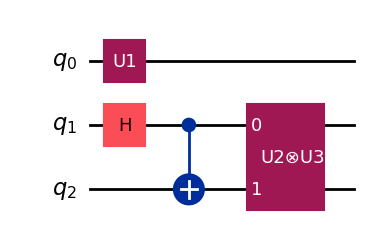

In [7]:
qc = QuantumCircuit(3)
qc.unitary(Operator(training[0]), [0], label="U1")
qc.h(1)
qc.cx(1,2)
U_ = np.kron(training[1],training[2])
qc.unitary(Operator(U_), [1,2], label="U2⊗U3")
qc.draw('mpl')

3. GHZ states:  $|\Psi_{\text{GHZ}}\rangle = \sqrt{K_{\text{GHZ}}} \left( \cos(\delta)|0\rangle|0\rangle|0\rangle + \sin(\delta)e^{i\phi} |\varphi_A\rangle |\varphi_B\rangle |\varphi_C\rangle \right)$

Where we find:

\begin{aligned}
|\varphi_A\rangle &= \cos(\alpha)|0\rangle + \sin(\alpha)|1\rangle \\
|\varphi_B\rangle &= \cos(\beta)|0\rangle + \sin(\beta)|1\rangle \\
|\varphi_C\rangle &= \cos(\gamma)|0\rangle + \sin(\gamma)|1\rangle\\
K_{\text{GHZ}} &= \frac{1}{1 + \cos(\delta) \sin(\delta) \cos(\alpha) \cos(\beta) \cos(\varphi)}
\end{aligned}
Where this parameters are bounded as: $(\alpha , \beta ,\gamma)\in (0,\pi/2]$, $\delta\in (0,\pi/4]$ and $\phi\in [0,2\pi)$

For this, I considered 4 qubits as to encode the cos(delta) sin(delta) I'll need to us a conditional rotation. Also, to encode the $\phi$ states the Ry gate we'll be needed as, acting on $|0\rangle$ it produces the desired states because:
$$RY(\theta) =
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix}$$

We need to say that it is important to only apply a second layer of RY if and only if the state is in |1>. For this purpose we need to use the conditional ry rotations.

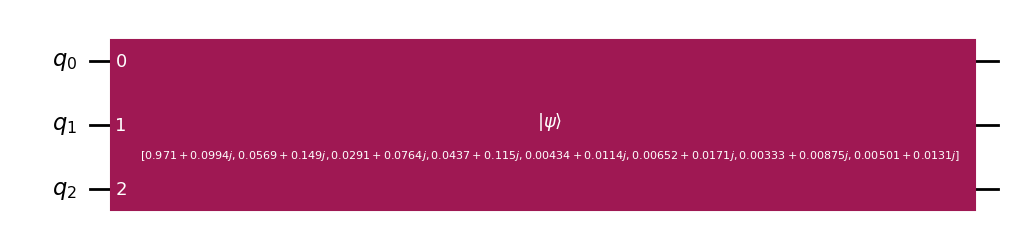

In [8]:
alpha_beta_gamma_bounds = (0, np.pi / 2)
delta_bounds = (0, np.pi / 4)
phi_bounds = (0, 2 * np.pi)
alpha = np.random.uniform(*alpha_beta_gamma_bounds)
beta = np.random.uniform(*alpha_beta_gamma_bounds)
gamma = np.random.uniform(*alpha_beta_gamma_bounds)
delta = np.random.uniform(*delta_bounds)
phi = np.random.uniform(*phi_bounds)
# Compute components
cos_d = np.cos(delta)
sin_d = np.sin(delta)
cos_phi = np.cos(phi)
cos_alpha = np.cos(alpha)
cos_beta = np.cos(beta)
cos_gamma = np.cos(gamma)
sin_alpha = np.sin(alpha)
sin_beta = np.sin(beta)
sin_gamma = np.sin(gamma)
# Componen
amp_000 = cos_d

# |φ_A φ_B φ_C>
phi_A = np.array([np.cos(alpha), np.sin(alpha)])
phi_B = np.array([np.cos(beta), np.sin(beta)])
phi_C = np.array([np.cos(gamma), np.sin(gamma)])

# Tensor product
phi_ABC = np.kron(np.kron(phi_A, phi_B), phi_C)
amp_phi = sin_d * np.exp(1j * phi)

# Normalization constant, using this normalization there is some error as it doesn't return 1 for the normalized state, thus I will normalize the state using numpy normalization
K_GHZ = 1 / (1 + cos_d * sin_d * cos_alpha * cos_beta * cos_gamma * cos_phi)
sqrt_K = np.sqrt(K_GHZ)

# Full state vector
state = np.zeros(8, dtype=complex)
state[0] = amp_000
state += amp_phi * phi_ABC
norm = np.linalg.norm(state)
state /= norm
# Create Statevector object
psi = Statevector(state)
qc = QuantumCircuit(3)
qc.initialize(psi, [0, 1, 2])
qc.draw('mpl')


3. W-states
For these states, we will use the following parameterized state:
$$|\psi_W \rangle  = K_W \left( a|001\rangle + b|010\rangle + c|100\rangle + d |000\rangle \right)$$
Where the parameters (a,b,c,d) are random parameters generated from a plain distribution in the interval (0,1).

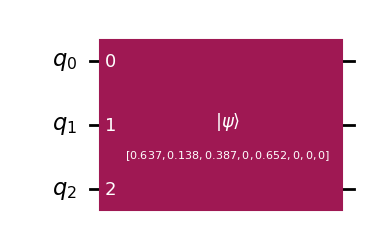

In [9]:

a, b, c, d = np.random.rand(4)

# Normalize
norm = np.sqrt(a**2 + b**2 + c**2 + d**2)
# We normalize the probabilities so the quantum state is normalized
a, b, c, d = a/norm, b/norm, c/norm, d/norm

# Define state vector in computational basis order: |000>, |001>, ..., |111>
state_vector = [d, a, b, 0, c, 0, 0, 0]

# Initialize circuit
qc = QuantumCircuit(3)
qc.initialize(state_vector, [0, 1, 2])
qc.draw('mpl')

## Three qubit entanglement detection

In [14]:
q=0
for i in range(0,int(len(training )/7),3):
    q+=1
print(f'State {q}')


State 95


In [15]:
def cost_fun(params,ansatz1,ansatz2,backend,cost_evolution_dict,q):
    ansatz2 = ansatz2.assign_parameters(params)
    isa_ansatz = transpile(ansatz1,backend=backend)
    isa_ansatz2 = transpile(ansatz2,backend=backend)
    sv1 = Statevector(isa_ansatz)
    sv2 = Statevector(isa_ansatz2)
    fid = state_fidelity(sv1,sv2)
    cost_evolution_dict[f"state_{q}"]["cost"].append(-fid)
    cost_evolution_dict[f"state_{q}"]["angles"].append(params)
    cost_evolution_dict[f"state_{q}"]["iteration"].append(len(cost_evolution_dict[f"state_{q}"]["iteration"])+1)
    return -fid

In [16]:
ansatz_sep = QuantumCircuit(3)
params = ParameterVector('θ',9)
ansatz_sep.ry(params[0],0)
ansatz_sep.rx(params[1],0)
ansatz_sep.rz(params[2],0)
ansatz_sep.rx(params[3],1)
ansatz_sep.ry(params[4],1)
ansatz_sep.rz(params[5],1)
ansatz_sep.rx(params[6],2)
ansatz_sep.ry(params[7],2)
ansatz_sep.rz(params[8],2)
real_label= []
q = 0
geom_entr = []
position_entangled = {'bipartite': [], 'ghz': [], 'w_state': []}
alpha_beta_gamma_bounds = (0, np.pi / 2)
delta_bounds = (0, np.pi / 4)
phi_bounds = (0, 2 * np.pi)
cost_evolution_dict = {}
for i in range(0,int(len(training)/12),3):
    print(f'State {q}')
    cost_evolution_dict[f"state_{q}"] = {"cost":[],
                                     "iteration":[],
                                     "angles":[]}
    x0 = np.random.rand(9) * 2 * np.pi
    rand_num = np.random.rand()
    # We select randomely if the generated state is entangled or not
    if rand_num <= 1/4:
        position_entangled['bipartite'].append(q)
        real_label.append(1)
        print('Bipartite')
        qc = QuantumCircuit(3)
        qc.unitary(Operator(training[i]), [0], label="U1")
        qc.h(1)
        qc.cx(1,2)
        U_ = np.kron(training[i+1],training[i+2])
        qc.unitary(Operator(U_), [1,2], label="U2⊗U3")
    elif rand_num>1/4 and rand_num<=2/4:
        position_entangled['ghz'].append(q)
        real_label.append(1)
        print('GHZ')
        alpha = np.random.uniform(*alpha_beta_gamma_bounds)
        beta = np.random.uniform(*alpha_beta_gamma_bounds)
        gamma = np.random.uniform(*alpha_beta_gamma_bounds)
        delta = np.random.uniform(*delta_bounds)
        phi = np.random.uniform(*phi_bounds)
        cos_d = np.cos(delta)
        sin_d = np.sin(delta)
        cos_phi = np.cos(phi)
        amp_000 = cos_d
        phi_A = np.array([np.cos(alpha), np.sin(alpha)])
        phi_B = np.array([np.cos(beta), np.sin(beta)])
        phi_C = np.array([np.cos(gamma), np.sin(gamma)])
        phi_ABC = np.kron(np.kron(phi_A, phi_B), phi_C)
        amp_phi = sin_d * np.exp(1j * phi)
        state = np.zeros(8, dtype=complex)
        state[0] = amp_000
        state += amp_phi * phi_ABC
        norm = np.linalg.norm(state)
        state /= norm
        psi_ghz = Statevector(state)
        qc = QuantumCircuit(3)
        qc.initialize(psi_ghz, [0, 1, 2])
    elif rand_num>2/4 and rand_num<=3/4:
        position_entangled['w_state'].append(q)
        real_label.append(1)
        print('W state')
        a, b, c, d = np.random.rand(4)
        norm = np.sqrt(a**2 + b**2 + c**2 + d**2)
        # We normalize the probabilities so the quantum state is normalized
        a, b, c, d = a/norm, b/norm, c/norm, d/norm
        # Define state vector in computational basis order: |000>, |001>, ..., |111>
        state_vector = [d, a, b, 0, c, 0, 0, 0]
        # Initialize circuit
        qc = QuantumCircuit(3)
        qc.initialize(state_vector, [0, 1, 2])
    elif rand_num>3/4:
        print("Separable")
        real_label.append(0)
        qc =QuantumCircuit(3)
        qc.unitary(Operator(np.array(training[i])), [0], label="U0")
        qc.unitary(Operator(np.array(training[i+1])), [1], label="U1")
        qc.unitary(Operator(np.array(training[i+2])), [2], label="U2")
        qc.barrier()
    res = minimize(cost_fun,x0,args = (qc,ansatz_sep,backend,cost_evolution_dict,q),method='cobyla',tol=0.0001)
    q+=1
    geom_entr.append(-res['fun'])

State 0
W state
State 1
GHZ
State 2
GHZ
State 3
GHZ
State 4
Separable
State 5
Separable
State 6
W state
State 7
GHZ
State 8
GHZ
State 9
Bipartite
State 10
Bipartite
State 11
Separable
State 12
GHZ
State 13
Separable
State 14
Separable
State 15
Bipartite
State 16
Separable
State 17
Separable
State 18
Separable
State 19
W state
State 20
W state
State 21
W state
State 22
Bipartite
State 23
GHZ
State 24
GHZ
State 25
W state
State 26
W state
State 27
Bipartite
State 28
Separable
State 29
Separable
State 30
Bipartite
State 31
W state
State 32
Bipartite
State 33
GHZ
State 34
Bipartite
State 35
Bipartite
State 36
GHZ
State 37
Bipartite
State 38
Separable
State 39
W state
State 40
W state
State 41
Separable
State 42
GHZ
State 43
W state
State 44
GHZ
State 45
W state
State 46
Separable
State 47
W state
State 48
GHZ
State 49
GHZ
State 50
Bipartite
State 51
Separable
State 52
W state
State 53
W state
State 54
Bipartite
State 55
GHZ


In [17]:
for key, value in cost_evolution_dict.items():
    cost_evolution_dict[key]["angles"] = [list(param) for param in value["angles"]]
    for q in range(len(value["angles"])):
        for i in range(len(value["angles"][q])):
            cost_evolution_dict[key]["angles"][q][i] = float(cost_evolution_dict[key]["angles"][q][i])
dict_result_1 = {"cost_evolution_dict": cost_evolution_dict,
                 "real_label": real_label,
                 "position_entangled": position_entangled,
                 "geom_entr": geom_entr}
with open('result_3qubits.json', 'w') as f:
    json.dump(dict_result_1, f, indent=4)


In [20]:
E = [(1 - p**2) for p in geom_entr]
print(E)
for i in range(len(E)):
    # I set a bound at 0.1 for classification of separable and entangled
    if E[i] < 0.0001:
        E[i]=0
    elif E[i]>=0.0001:
        E[i]=1
q= 0
for z in range(len(real_label)):
    if E[z]==real_label[z]:
        q+=1
print(f'The method`s accuaracy is {(q/len(real_label))*100} %')

[np.float64(0.02077103659869739), np.float64(0.15079605752963432), np.float64(0.07011194407012933), np.float64(0.2931073850532475), np.float64(4.0441272552982355e-09), np.float64(5.082093856856318e-09), np.float64(0.15312020247342661), np.float64(0.0013491139925239093), np.float64(0.01010920482662303), np.float64(0.7500000010415342), np.float64(0.7500000017101343), np.float64(1.2976739682812877e-09), np.float64(0.15385555172204957), np.float64(7.61066276666611e-09), np.float64(3.828930505989092e-09), np.float64(0.7500000011898135), np.float64(9.014504254167832e-09), np.float64(4.422002319870444e-09), np.float64(3.326177999696256e-09), np.float64(0.3167977068170007), np.float64(0.5031646492636833), np.float64(0.03945122748185759), np.float64(0.7500000003562446), np.float64(0.029424289943259962), np.float64(0.268796112614479), np.float64(0.17899856952573656), np.float64(0.17965149552450188), np.float64(0.750000002982), np.float64(3.835111339611785e-09), np.float64(3.1898852448364323e-09)

In [ ]:
position_entangled

With the following image we can see for any state the maximization process to see when the optimum is obtained

(0.0, 1.0)

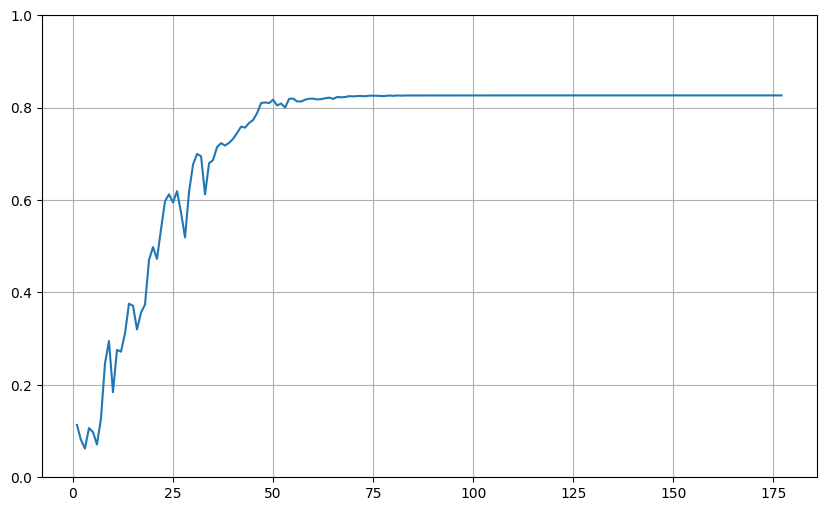

In [23]:
plt.figure(figsize=(10, 6))
cost = cost_evolution_dict["state_19"]
plt.plot(cost["iteration"], np.abs(cost["cost"]), label="State 0")
plt.grid()
plt.ylim(0, 1)

## Study of entanglement meassure for each entagled state
In this part I study the numerical value of the entanglement meassure for each type of the entangled states to see if any classification through this meassure is possible

In [ ]:
from collections import defaultdict
cost_evolution_dict_bipartite = defaultdict(lambda: {
    "cost": [], "angles": [], "iteration": [], "population": []
})

In [ ]:
def cost_fun(params,ansatz1,ansatz2,backend):
    ansatz2 = ansatz2.assign_parameters(params)
    isa_ansatz = transpile(ansatz1,backend=backend)
    isa_ansatz2 = transpile(ansatz2,backend=backend)
    sv1 = Statevector(isa_ansatz)
    sv2 = Statevector(isa_ansatz2)
    fid = state_fidelity(sv1,sv2)
    return -fid

In [ ]:
def wrapped_cost_fun(x, qc, ansatz_sep, backend, q):
    cost = cost_fun(x, qc, ansatz_sep, backend)

    # Store info on each function evaluation
    state = f"state_{q}"
    cost_evolution_dict_bipartite[state]["cost"].append(cost)
    cost_evolution_dict_bipartite[state]["angles"].append(x)
    cost_evolution_dict_bipartite[state]["iteration"].append(
        len(cost_evolution_dict_bipartite[state]["iteration"]) + 1
    )
    # If you had population info, you'd log it here
    return cost

In [ ]:
ansatz_sep = QuantumCircuit(3)
params = ParameterVector('θ',9)
ansatz_sep.ry(params[0],0)
ansatz_sep.rx(params[1],0)
ansatz_sep.rz(params[2],0)
ansatz_sep.rx(params[3],1)
ansatz_sep.ry(params[4],1)
ansatz_sep.rz(params[5],1)
ansatz_sep.rx(params[6],2)
ansatz_sep.ry(params[7],2)
ansatz_sep.rz(params[8],2)
q = 0
geom_entr_bipartite = []
cost_evolution_dict_bipartite = {}
bounds =[(-np.pi, np.pi)]*ansatz_sep.num_parameters
for i in range(0,int(len(training)/50),3):
    print(f'State {q}')
    x0 = np.random.rand(9) * 2 * np.pi
    qc = QuantumCircuit(3)
    qc.unitary(Operator(training[i]), [0], label="U1")
    qc.h(1)
    qc.cx(1,2)
    U_ = np.kron(training[i+1],training[i+2])
    qc.unitary(Operator(U_), [1,2], label="U2⊗U3")
    res = differential_evolution(lambda x: wrapped_cost_fun(x, qc, ansatz_sep, backend, q),
    bounds,
    strategy='best1exp',
    maxiter=100,
    popsize=1,
    tol=0.001
)
    q+=1
    geom_entr_bipartite.append(-res['fun'])

State 5
State 6
State 7
State 8
State 9


In [ ]:
params = ParameterVector('θ',9)
ansatz_sep = QuantumCircuit(3)
ansatz_sep.ry(params[0],0)
ansatz_sep.rx(params[1],0)
ansatz_sep.rz(params[2],0)
ansatz_sep.rx(params[3],1)
ansatz_sep.ry(params[4],1)
ansatz_sep.rz(params[5],1)
ansatz_sep.rx(params[6],2)
ansatz_sep.ry(params[7],2)
ansatz_sep.rz(params[8],2)
alpha_beta_gamma_bounds = (0, np.pi / 2)
delta_bounds = (0, np.pi / 4)
phi_bounds = (0, 2 * np.pi)
q = 0
geom_entr_GHZ = []
cost_evolution_dict_GHZ = {}
for i in range(0,int(len(training)/50),3):
    cost_evolution_dict_GHZ[f"state_{q}"] = {"cost":[],
                                     "iteration":[],
                                     "angles":[]}
    x0 = np.random.rand(9) * 2 * np.pi
    alpha = np.random.uniform(*alpha_beta_gamma_bounds)
    beta = np.random.uniform(*alpha_beta_gamma_bounds)
    gamma = np.random.uniform(*alpha_beta_gamma_bounds)
    delta = np.random.uniform(*delta_bounds)
    phi = np.random.uniform(*phi_bounds)
    cos_d = np.cos(delta)
    sin_d = np.sin(delta)
    cos_phi = np.cos(phi)
    amp_000 = cos_d
    phi_A = np.array([np.cos(alpha), np.sin(alpha)])
    phi_B = np.array([np.cos(beta), np.sin(beta)])
    phi_C = np.array([np.cos(gamma), np.sin(gamma)])
    phi_ABC = np.kron(np.kron(phi_A, phi_B), phi_C)
    amp_phi = sin_d * np.exp(1j * phi)
    state = np.zeros(8, dtype=complex)
    state[0] = amp_000
    state += amp_phi * phi_ABC
    norm = np.linalg.norm(state)
    state /= norm
    psi = Statevector(state)
    qc = QuantumCircuit(3)
    qc.initialize(psi, [0, 1, 2])
    res = diff(cost_fun,x0,args = (qc,ansatz_sep,backend,cost_evolution_dict_GHZ,q),method='cobyla',tol=0.01)
    q+=1
    geom_entr_GHZ.append(-res['fun'])

In [ ]:
params = ParameterVector('θ',9)
ansatz_sep = QuantumCircuit(3)
ansatz_sep.ry(params[0],0)
ansatz_sep.rx(params[1],0)
ansatz_sep.rz(params[2],0)
ansatz_sep.rx(params[3],1)
ansatz_sep.ry(params[4],1)
ansatz_sep.rz(params[5],1)
ansatz_sep.rx(params[6],2)
ansatz_sep.ry(params[7],2)
ansatz_sep.rz(params[8],2)
q = 0
geom_entr_W = []
cost_evolution_dict_W = {}
for i in range(0,int(len(training)/50),3):
    cost_evolution_dict_W[f"state_{q}"] = {"cost":[],
                                     "iteration":[],
                                     "angles":[]}
    x0 = np.random.rand(9) * 2 * np.pi
    a, b, c, d = np.random.rand(4)
    norm = np.sqrt(a**2 + b**2 + c**2 + d**2)
    # We normalize the probabilities so the quantum state is normalized
    a, b, c, d = a/norm, b/norm, c/norm, d/norm
    # Define state vector in computational basis order: |000>, |001>, ..., |111>
    state_vector = [d, a, b, 0, c, 0, 0, 0]
    # Initialize circuit
    qc = QuantumCircuit(3)
    qc.initialize(state_vector, [0, 1, 2])
    res = minimize(cost_fun,x0,args = (qc,ansatz_sep,backend,cost_evolution_dict_W,q),method='cobyla',tol=0.01)
    q+=1
    geom_entr_W.append(-res['fun'])

In [ ]:
E_GHZ = [(1 - p**2) for p in geom_entr_GHZ]
E_W = [(1 - p**2) for p in geom_entr_W]
E_bi = [(1 - p**2) for p in geom_entr_bipartite]
data = pd.DataFrame({
    'Geometric Entanglement': E_GHZ + E_W + E_bi,
    'State Type': ['GHZ']*len(E_GHZ) + ['W']*len(E_W) + ['Bipartite']*len(E_bi)
})
data.to_csv('ent_measure_3qub.csv')

In [24]:
df = pd.read_csv("./ent_measure_3qub.csv")
E_GHZ = df[df['State Type'] == 'GHZ']['Geometric Entanglement'].tolist()
E_W = df[df['State Type'] == 'W']['Geometric Entanglement'].tolist()
E_bi = df[df['State Type'] == 'Bipartite']['Geometric Entanglement'].tolist()

C:\Users\aquim\AppData\Local\Temp\ipykernel_11508\1154567305.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='State Type', y='Geometric Entanglement',palette=palette,width=0.5)


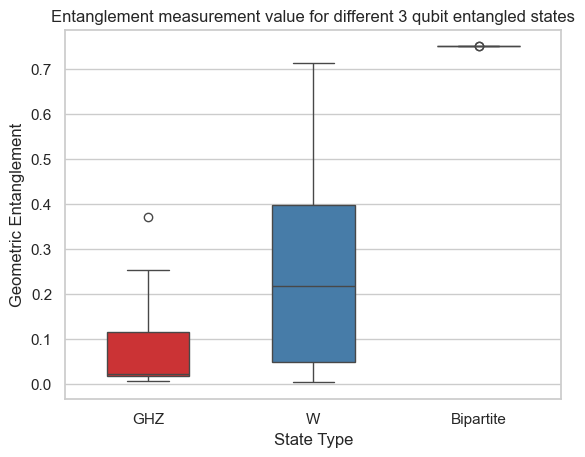

In [26]:

sns.set(style="whitegrid")
palette = {
    'GHZ': sns.color_palette("Set1")[0],
    'W': sns.color_palette("Set1")[1],
    'Bipartite': sns.color_palette("Set1")[2],
}
# Create a boxplot
sns.boxplot(data=df, x='State Type', y='Geometric Entanglement',palette=palette,width=0.5)
#sns.stripplot(data=data, x='State Type', y='Geometric Entanglement', color='blue', size=6, jitter=True, alpha=0.5)

plt.title('Entanglement measurement value for different 3 qubit entangled states')
plt.ylabel('Geometric Entanglement')
plt.xlabel('State Type')
plt.show()

# TO DOS:
1. Study the non-maximally entangled and mixed separable states.
2. Consider SVM.
3. Problem using GHZ parameterized state. GHZ using STATEVECTOR✅
4. Cost function plot!!✅
5. Separability and Entanglement theory.
6. ¿Try to differenciate between entangled states? Maybe check the entanglement meassure. ❔​
7. Maybe try executing circuits and not using the statevector simulator.
8. Improve optimizer and lower tolerance.
9. signal vs background
10. roc curve
11. confussion matrix